# Master Thesis Notebook

## Setup

In [16]:
# Import libraries
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pykrige.ok import OrdinaryKriging
from rasterio.warp import reproject, Resampling
from skgstat import models
from sklearn.preprocessing import QuantileTransformer
import glob
import gstatsim as gs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj  # for reprojection
import rasterio
import skgstat as skg

In [17]:
# Fields paths
field_a_paths = glob.glob(
    "D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt"
)  # return all file paths that match a specific pattern
field_b_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field B/*.txt")

In [18]:
sample_number = 0  # [0-10]
field_path = field_a_paths  # field_a_paths or field_b_paths

In [19]:
# Define the transformer for WGS84 to UTM (UTM zone 32N)
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)

## Functions

In [20]:
# Import data function
gpr_data_tables = []


def import_data(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    gpr_data_tables = []
    for file_path in file_paths:
        data_frame = pd.read_csv(file_path, sep="  ", engine="python")  # read csv file
        data_frame.columns = ["y", "x", "vwc"]  # rename columns
        gpr_data_tables.append(data_frame)

    return gpr_data_tables


# Extract dates function
dates = []


def extract_dates(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        file_name_without_extension = os.path.splitext(file_name)[0]
        date = (
            file_name_without_extension[4:6]
            + "/"
            + file_name_without_extension[2:4]
            + "/"
            + "20"
            + file_name_without_extension[:2]
        )
        dates.append(date)

    return dates


# Letter of the field
if field_path == field_a_paths:
    field_letter = "A"
else:
    field_letter = "B"

# Date of the files
extract_dates(field_path)

import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import matplotlib.pyplot as plt


# Define functions for T_max and T_min
def t_max(ndvi):
    # Placeholder coefficients for T_max(NDVI) = a * NDVI + b
    a = 40
    b = 300
    return a * ndvi + b


def t_min(ndvi):
    # Placeholder coefficients for T_min(NDVI) = c * NDVI + d
    c = 20
    d = 250
    return c * ndvi + d


# Calculate TVDI
def calculate_tvdi(temperature_raster, ndvi_raster):
    # Read temperature raster
    with rasterio.open(temperature_raster) as temp_src:
        temperature = temp_src.read(1)
        temp_profile = temp_src.profile

    # Read NDVI raster
    with rasterio.open(ndvi_raster) as ndvi_src:
        ndvi = ndvi_src.read(1)
        ndvi_profile = ndvi_src.profile

    # Resample NDVI to match temperature raster dimensions
    ndvi_resampled = np.zeros_like(temperature)
    reproject(
        ndvi,
        ndvi_resampled,
        src_transform=ndvi_src.transform,
        src_crs=ndvi_src.crs,
        dst_transform=temp_profile["transform"],
        dst_crs=temp_profile["crs"],
        resampling=Resampling.nearest,
        dst_resolution=(temp_profile["transform"][0], -temp_profile["transform"][4]),
    )

    # Calculate T_max and T_min
    t_max_values = t_max(ndvi_resampled)
    t_min_values = t_min(ndvi_resampled)

    # Calculate TVDI
    tvdi = (temperature - t_min_values) / (t_max_values - t_min_values)

    # Set nodata value to -9999
    tvdi[np.isnan(tvdi)] = -9999

    # Adjusting TVDI range to 0-255 for storing as unsigned 8-bit integer
    tvdi_adjusted = ((tvdi - tvdi.min()) / (tvdi.max() - tvdi.min()) * 255).astype(np.uint8)

    # Write TVDI to a new raster
    tvdi_profile = temp_profile.copy()
    tvdi_profile.update(dtype=rasterio.uint8, count=1, nodata=np.uint8(-9999))

    with rasterio.open(r"D:\Coding\Master-Thesis\tvdii.tif", "w", **tvdi_profile) as dst:
        dst.write(tvdi_adjusted, 1)

    # Plot TVDI
    plt.imshow(tvdi_adjusted, cmap="jet", vmin=0, vmax=255)
    plt.colorbar(label="TVDI")
    plt.title("Temperature Vegetation Dryness Index (TVDI)")
    plt.show()

## Field VWC data overview

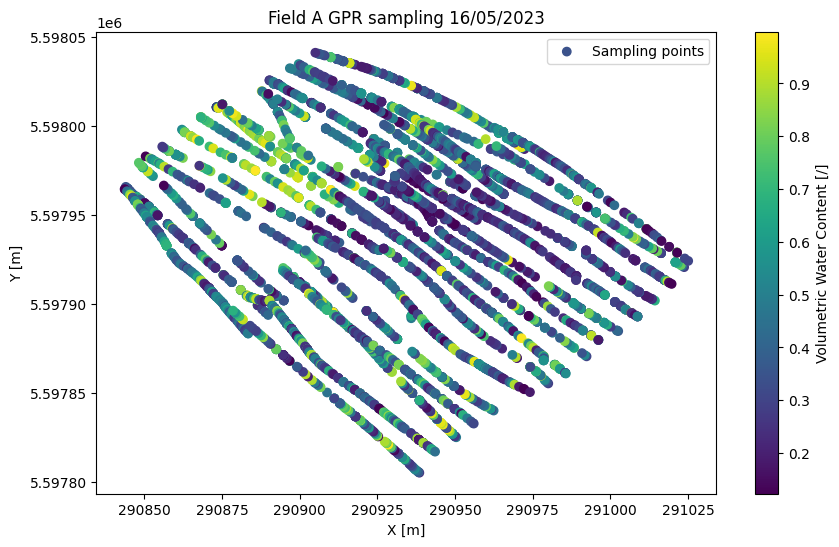

In [21]:
# Read csv file
Studied_field = import_data(field_path)[sample_number]

# Convert latitude and longitude to UTM coordinates
utm_x, utm_y = transformer.transform(Studied_field["x"].values, Studied_field["y"].values)

# Plot the sampling points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(utm_x, utm_y, c=Studied_field["vwc"], cmap="viridis", label="Sampling points")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title(f"Field {field_letter} GPR sampling {dates[sample_number]}")
cb = plt.colorbar(scatter)
cb.set_label("Volumetric Water Content [/]")
plt.grid(False)
plt.legend()
plt.show()

### Volumetric water content evolution of field A

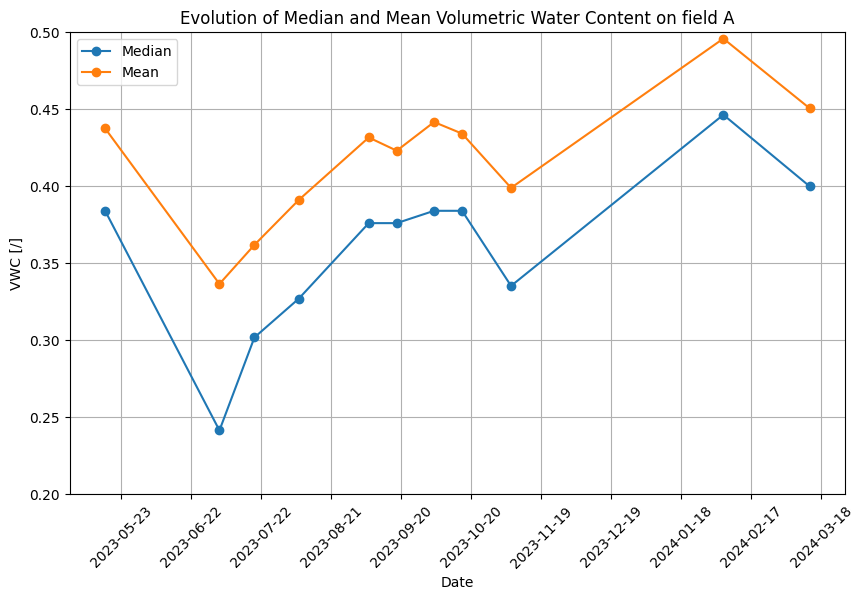

In [22]:
# Reset
gpr_data_tables = []
dates = []

gpr_data_tables = import_data(field_path)

mean_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    mean_GPR_data_table = gpr_data_table["vwc"].mean()
    mean_GPR_data_tables.append(mean_GPR_data_table)

median_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    median_GPR_data_table = gpr_data_table["vwc"].median()
    median_GPR_data_tables.append(median_GPR_data_table)

dates = extract_dates(field_path)

# Convert dates to datetime objects
dates = pd.to_datetime(dates, format="%d/%m/%Y")

plt.figure(figsize=(10, 6))
plt.plot(dates, median_GPR_data_tables, marker="o", label="Median")
plt.plot(dates, mean_GPR_data_tables, marker="o", label="Mean")
plt.xlabel("Date")
plt.ylabel("VWC [/]")
plt.title("Evolution of Median and Mean Volumetric Water Content on field A")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.ylim(0.2, 0.5)
plt.grid(True)
plt.legend()
plt.show()


# Reset
gpr_data_tables = []
dates = []

### Volumetric water content evolution of field B

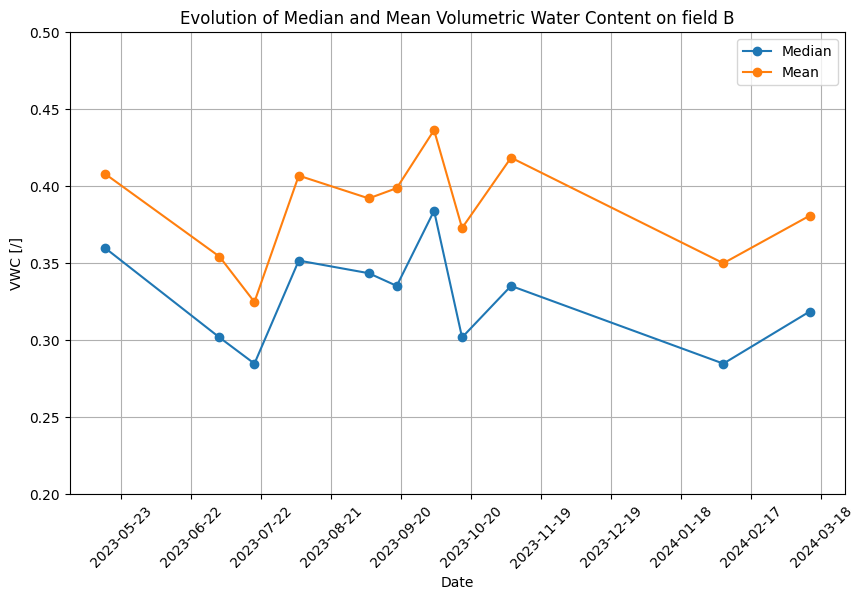

In [23]:
gpr_data_tables = import_data(field_b_paths)

mean_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    mean_GPR_data_table = gpr_data_table.iloc[:, 2].mean()
    mean_GPR_data_tables.append(mean_GPR_data_table)

median_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    median_GPR_data_table = gpr_data_table.iloc[:, 2].median()
    median_GPR_data_tables.append(median_GPR_data_table)

dates = extract_dates(field_b_paths)

# Convert dates to datetime objects
dates = pd.to_datetime(dates, format="%d/%m/%Y")

plt.figure(figsize=(10, 6))
plt.plot(dates, median_GPR_data_tables, marker="o", label="Median")
plt.plot(dates, mean_GPR_data_tables, marker="o", label="Mean")
plt.xlabel("Date")
plt.ylabel("VWC [/]")
plt.title("Evolution of Median and Mean Volumetric Water Content on field B")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.ylim(0.2, 0.5)
plt.grid(True)
plt.legend()
plt.show()

# Reset
gpr_data_tables = []
dates = []

## Kriging
Kriging is a type of interpolation that uses a semivariogram, which measures spatial autocorrelation (how similar close points are in value and how this similarity changes as distance between points increases). Thus, the semivariogram determines how much influence a known point has on an unknown point as the distance between the known point and the unknown point increases. In other words, the weight of a known point on an unknown point decreases with increasing distance, and the semivariogram determines how quickly that weight tapers with increasing distance

### Choosing the fitting Variogram Model

The semivariogram, often just referred to as the variogram, is used to quantify spatial dependence for irregularly spaced data. It computes the average variance of the difference between two data points with a given separation distance, or lag distance $\bf{h}$.

$$
\gamma(h) = \frac{1}{2 N(h)} \sum^{N}_{\alpha=1} (Z(x_\alpha) - Z(x_\alpha + h))^2  
$$


where $x$ is a spatial location, $Z(x)$ is a variable (e;g. water content), and $N$ is the number of lag distances.

We'll start by computing the isotropic variogram, which averages across different azimuthal directions using the Scikit GStat tools. 

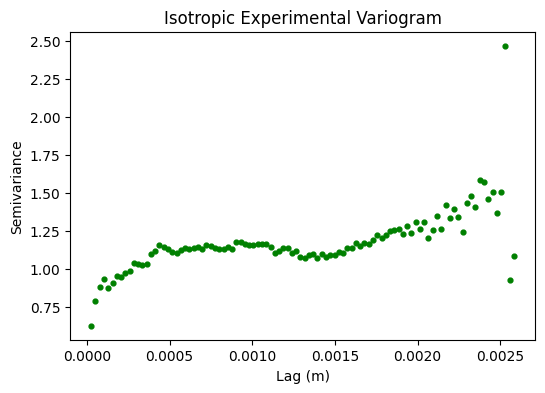

In [24]:
# grid data to ? m resolution
res = 0.00002
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(Studied_field, "x", "y", "vwc", res)

# remove nans
df_grid = df_grid[df_grid["Z"].isnull() == False]

# normal score transformation
data = df_grid["Z"].values.reshape(-1, 1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid["Nbed"] = nst_trans.transform(data)

# compute experimental (isotropic) variogram
coords = df_grid[["X", "Y"]].values
values = df_grid["Nbed"]

maxlag = 10  # maximum range distance
n_lags = 100  # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func="even", n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6, 4))
plt.scatter(xdata, ydata, s=12, c="g")
plt.title("Isotropic Experimental Variogram")
plt.xlabel("Lag (m)")
plt.ylabel("Semivariance")
plt.show()

In [25]:
# use exponential variogram model
V1.model = "exponential"
V1.parameters

# use Gaussian model
V2 = V1
V2.model = "gaussian"
V2.parameters

# use spherical model
V3 = V1
V3.model = "spherical"
V3.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], 100)

y_exp = [models.exponential(h, V1.parameters[0], V1.parameters[1], V1.parameters[2]) for h in xi]
y_gauss = [models.gaussian(h, V2.parameters[0], V2.parameters[1], V2.parameters[2]) for h in xi]
y_sph = [models.spherical(h, V3.parameters[0], V3.parameters[1], V3.parameters[2]) for h in xi]

# plot variogram model
fig = plt.figure()
plt.plot(xdata / 1000, ydata, "og", label="Experimental variogram")
plt.plot(xi / 1000, y_gauss, "b--", label="Gaussian variogram")
plt.plot(xi / 1000, y_exp, "r-", label="Exponential variogram")
plt.plot(xi / 1000, y_sph, "m*-", label="Spherical variogram")
plt.title("Isotropic variogram")
plt.xlabel("Lag [km]")
plt.ylabel("Semivariance")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0)  # adjust the plot size
plt.legend(loc="lower right")

fig = plt.figure()
plt.plot(xdata / 1000, ydata, "og", label="Experimental variogram")
plt.plot(xi / 1000, y_gauss, "b--", label="Gaussian variogram")
plt.plot(xi / 1000, y_exp, "r-", label="Exponential variogram")
plt.plot(xi / 1000, y_sph, "m*-", label="Spherical variogram")
plt.title("Isotropic variogram")
plt.xlim(0, 0.0000003)
plt.xlabel("Lag [km]")
plt.ylabel("Semivariance")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0)  # adjust the plot size
plt.legend(loc="lower right")

### Ordinary Kriging with exponential variogram

In [ ]:
# Define your prediction grid
x_min, x_max = min(Studied_field["x"]), max(Studied_field["x"])
y_min, y_max = min(Studied_field["y"]), max(Studied_field["y"])

gridx = np.arange(x_min, x_max, 0.00001)  # Adjust the step size as needed
gridy = np.arange(y_min, y_max, 0.00001)  # Adjust the step size as needed

In [ ]:
OK = OrdinaryKriging(
    Studied_field["x"],
    Studied_field["y"],
    Studied_field["vwc"],
    variogram_model="exponential",
    verbose=False,
    enable_plotting=False,
)

z, ss = OK.execute("grid", gridx, gridy)

In [ ]:
# Convert the kriging results to a suitable format for further processing or plotting
z_grid = z.T  # Transpose the result to match the grid shape

# Example: Convert to DataFrame for easy handling
result_df = pd.DataFrame(z_grid, index=gridx, columns=gridy)

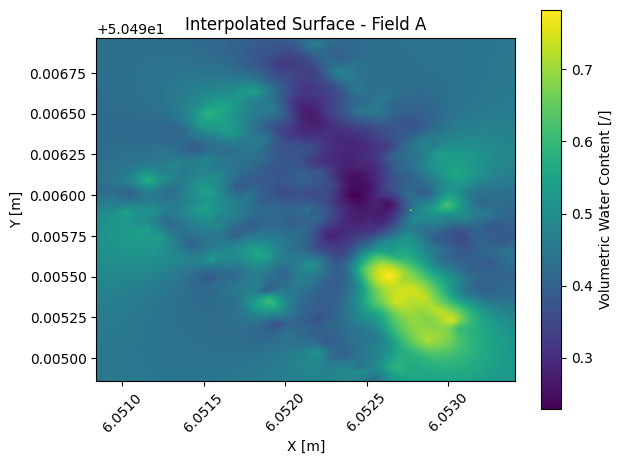

In [ ]:
# Plot the interpolated surface

plt.imshow(z_grid, extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()], origin="lower", cmap="viridis")
plt.colorbar(label="Volumetric Water Content [/]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.xticks(rotation=45)
plt.title(f"Interpolated Surface - Field {field_letter}")
plt.grid(False)

plt.tight_layout()
plt.show()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


In [ ]:
temperature_raster = "D:/Cours bioingé/BIR M2/Mémoire/Data/thermal/MR20240205_georeferenced_thermal_cali.tif"
ndvi_raster = "D:/Cours bioingé/BIR M2/Mémoire/Data/multispectral/NDVI/MR20230719_georeferenced_multi_ndvi.tif"
calculate_tvdi(temperature_raster, ndvi_raster)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_22628\1715020060.py:106: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -9999 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  tvdi_profile.update(dtype=rasterio.uint8, count=1, nodata=np.uint8(-9999))


RasterioIOError: Attempt to create new tiff file 'D:/Coding/Master-Thesis/tvdii.tif' failed: No such file or directory

## Multispectral vs GPR